# Recommendation System Project
##### [1. Word Cloud Generation with "지원동기"](#1.-Word-Cloud-Generation)
##### [2. Topic Modeling to extract values](#2.-Topic-Modeling)
##### [3. FFM Prediction](#3.-FFM)
##### [4. KGAT](#4.-KGAT)

## 1. Word Cloud Generation

department_standardized_data.csv's valid motivs: 2125 out of 2151
total valid reasons: 2125


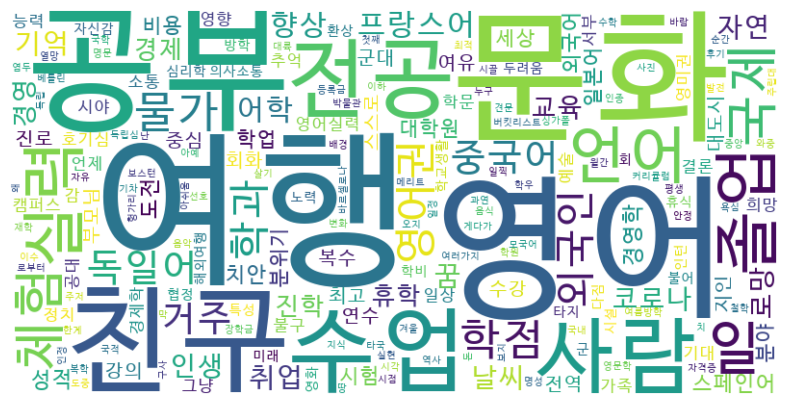

In [26]:
from utils.extract_helper import *
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from konlpy.tag import Mecab
from konlpy.tag import Okt
import os

path_to_files = "data_set"
files_to_process = ["page_1_to_10.csv", "page_11_to_22.csv", "page_23_to_100.csv", "page_101_to_200.csv", "page_201_to_300.csv", "page_301_to_376.csv"]

files_to_process = ["department_standardized_data.csv"]

# 불용어 처리
stopwords = set()
with open("stopwords.txt", 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()  # 기본적으로 공백을 기준으로 split
        stopwords.update(words)  # set에 words 추가 (중복 제거)

# 각 파일에서 '지원 동기'에 해당하는 부분 parse
mecab = Mecab()                     # mecab 형태소 분석기 생성
cleaned_text = ""                   # 워드 클라우드에 들어갈 긴 string
total_motiv_cnt = 0                 # 유효한 지원동기 개수

mecab = Okt() # okt 사용시 uncomment

# topic modeling, ffm에 사용될 df
df_features = pd.DataFrame()

for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    
    # csv 파일 내용 parse
    # df['Selected Content'] = df.apply(select_content, axis=1)
    # df['Processed Content'] = df.apply(process_content, axis=1)
    df['Processed Content'] = df['Processed Content'].apply(lambda x : preprocess_text(x, stopwords, mecab))
    tot_len = len(df['Processed Content'])

    motivs = df['Processed Content'].dropna() # NAN 제거
    motivs = motivs[motivs.str.strip() != ""]  # 빈 문자열 제거

    print(f"{file_name}'s valid motivs: {len(motivs)} out of {tot_len}")
    total_motiv_cnt += len(motivs)
    
    df_features = pd.concat([df_features, df[['Semester', 'School', 'Country', 'Major1', 'Processed Content']]])
    
    # 텍스트 전처리
    text = ' '.join(motivs)  # 모든 텍스트를 결합

    # 명사 리스트를 하나의 문자열로 변환
    cleaned_text += ' ' + text

print(f"total valid reasons: {total_motiv_cnt}")

# WordCloud 객체 생성
cleaned_text = cleaned_text.split()
cleaned_text_cnt = Counter(cleaned_text)
min_freq = 10
cleaned_text_flt = {word: count for word, count in cleaned_text_cnt.items() if count >= min_freq}

font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate_from_frequencies(cleaned_text_flt)

# 워드 클라우드 표시
plt.figure(figsize=(10, 5))
plt.rc('font', family='AppleGothic')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축 제거
plt.show()

## 2. Topic Modeling

Try find the "optimal" number of topics

Number of Topics: 2, Perplexity: 395.9034908097579, Coherence: 0.513591381374993
Number of Topics: 3, Perplexity: 407.02911811926816, Coherence: 0.535981147534073
Number of Topics: 4, Perplexity: 420.586109470984, Coherence: 0.5436192907710056
Number of Topics: 5, Perplexity: 428.1232656751499, Coherence: 0.5024697596879805
Number of Topics: 6, Perplexity: 442.0304693994766, Coherence: 0.47599334629830103
Number of Topics: 7, Perplexity: 444.5652320555285, Coherence: 0.5219646172310025
Number of Topics: 8, Perplexity: 450.7633536808686, Coherence: 0.5186773558131346
Number of Topics: 9, Perplexity: 460.8396373471315, Coherence: 0.4900521205612825
Number of Topics: 10, Perplexity: 465.8406052134383, Coherence: 0.47879471466327306


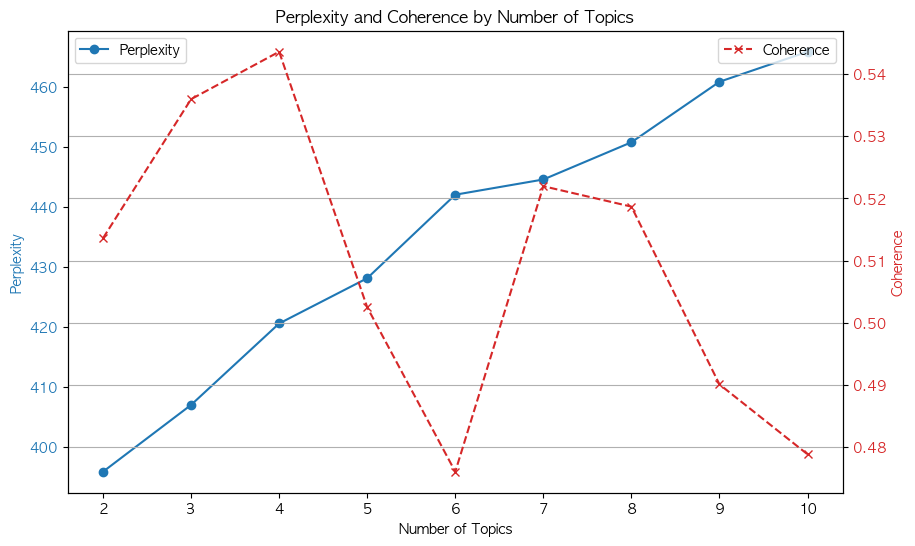

In [27]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# 지원 동기 부분만 추출해서 사용
total_motivs = df_features['Processed Content'].reset_index(drop=True)

texts = df_features['Processed Content'].tolist()
texts = [str(x).split() if isinstance(x, str) else x for x in texts]
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# 문서-단어 행렬 생성
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(total_motivs)

# 토픽 수별 Perplexity 계산
max_topics = 10
perplexities = []
coherences = []

for num_topics in range(2, max_topics + 1):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # perplexity 계산
    perplexity = lda.perplexity(X)
    perplexities.append(perplexity)

    # 각 주제당 top word
    topics = [
        [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
        for topic in lda.components_
    ]
    
    # Coherence 계산
    coherence_model = CoherenceModel(
        topics=topics, texts=texts, dictionary=id2word, coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherences.append(coherence)

    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity}, Coherence: {coherence}")


fig, ax1 = plt.subplots(figsize=(10, 6))

# Perplexity
color = 'tab:blue'
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Perplexity", color=color)
ax1.plot(range(2, max_topics + 1), perplexities, marker='o', color=color, label="Perplexity")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Coherence
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Coherence", color=color)
ax2.plot(range(2, max_topics + 1), coherences, marker='x', linestyle='--', color=color, label="Coherence")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')


plt.title("Perplexity and Coherence by Number of Topics")
plt.grid()
plt.show()

In [31]:
import pyLDAvis

# 위에 결과에서 '최적'의 토픽 수 선정
optimal_topic_number = 4

# 빈 거 드랍
valid_motivs = df_features['Processed Content'].dropna()
valid_motivs = valid_motivs[valid_motivs.str.strip() != ""]  # 빈 문자열 제거
valid_motivs = valid_motivs.reset_index(drop=True)  # 인덱스 재설정

# LDA 모델 학습
num_topics = optimal_topic_number  # 주제 수
X = vectorizer.fit_transform(valid_motivs)

lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# 주제별 상위 단어 출력
terms = vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"\n주제 {idx + 1}:")
    print([terms[i] for i in topic.argsort()[:-11:-1]])

# 문서별 주제 분포 출력
doc_topics = lda.transform(X)
doc_topic_df = pd.DataFrame(doc_topics, columns=[f"주제 {i + 1}" for i in range(num_topics)])
doc_topic_df['Value'] = doc_topic_df.idxmax(axis=1)
doc_topic_df['Value'] = doc_topic_df['Value'].str.replace('주제 ', '').astype(int)
doc_topic_df['Processed Content'] = valid_motivs

# 데이터에 value 항목 추가
df_features = df_features.merge(doc_topic_df[['Processed Content', 'Value']], on='Processed Content', how='left')
df_features.to_csv('ffm_input_data_okt.csv', index=False, header=True, encoding='utf-8-sig')

# 문서-단어 행렬과 LDA 모델 결과를 시각화에 맞게 변환
lda_vis_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_,          # LDA 주제-단어 분포
    doc_topic_dists=lda.transform(X),         # 문서-주제 분포
    doc_lengths=X.sum(axis=1).A1,             # 각 문서의 단어 수
    vocab=vectorizer.get_feature_names_out(), # 단어 목록
    term_frequency=X.sum(axis=0).A1          # 전체 단어 빈도
)

# 시각화 출력
pyLDAvis.display(lda_vis_data)
pyLDAvis.save_html(lda_vis_data, f'lda_visualization/lda_visualization_{optimal_topic_number}.html')


주제 1:
['공부', '독일어', '수업', '전공', '친구', '문화', '학점', '스페인어', '영어', '사람']

주제 2:
['여행', '친구', '공부', '문화', '졸업', '사람', '수업', '국제', '전공', '로망']

주제 3:
['영어', '여행', '문화', '공부', '실력', '수업', '중국어', '언어', '향상', '프랑스어']

주제 4:
['문화', '여행', '전공', '사람', '경영', '경영학', '친구', '경제', '수업', '물가']


## 3. FFM

process data to fit the template described in the paper - categorical variables(value is always 1)

**label field:feat:value**


`yes school:name-upenn:1 school:country-usa:1 student:semester-1:1 student:major1-computerscience:1 student:value-0:1`

`yes school:name-tum:1 school:country-usa:1 student:semester-2:1 student:major1-business:1 student:value-1:1`

# 4. KGAT

**txt files for training and testing**  
user: students  
item: schools  
| user | item |
|---|---|
| Gayeon | Upenn |
| Hannah | Tum |
...

**txt file for kg graph**  
entities: major1, value, semester, country  
relations: majors_in, prioritizes, wanted_to_visit, important_to

| head_entity | relation | tail_entity |
|---|---|---|
| CS | important_to | study |
| Gayeon | majors_in | CS |
...

*nl will be encoded into numbers*

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# encode the data
fields = ["Semester", "School", "Country", "Major1", "Value"]
encoders = {field: LabelEncoder().fit(df_features[field].astype(str)) for field in fields}
encoded_df = df_features[fields].apply(lambda col: encoders[col.name].transform(col.astype(str)))
print(encoded_df)

# split training and test set
student_school_pairs = [(idx, school) for idx, school in zip(encoded_df.index, encoded_df['School'])]
train_pairs, test_pairs = train_test_split(student_school_pairs, test_size=0.2, random_state=42)

# training set
with open("data_set/train.txt", "w") as train_file:
    for student_id, school in train_pairs:
        train_file.write(f"{student_id} {school}\n")

# test set
with open("data_set/test.txt", "w") as test_file:
    for student_id, school in test_pairs:
        test_file.write(f"{student_id} {school}\n")

# create relations graph
with open("data_set/kg_final.txt", "w") as kg_final:
    for i in encoded_df.index:
        kg_final.write(f"{i} 1 {encoded_df['Major1'][i]}\n")                             # majors in
        kg_final.write(f"{i} 2 {encoded_df['Value'][i]}\n")                              # prioritizes
        kg_final.write(f"{i} 3 {encoded_df['Semester'][i]}\n")                           # went at
        kg_final.write(f"{i} 4 {encoded_df['Country'][i]}\n")                            # wanted to visit
        kg_final.write(f"{encoded_df['Major1'][i]} 5 {encoded_df['Value'][i]}\n")        # important
        kg_final.write(f"{encoded_df['Major1'][i]} 6 {encoded_df['School'][i]}\n")       # is famous at
        kg_final.write(f"{encoded_df['Value'][i]} 7 {encoded_df['School'][i]}\n")        # is a good place to
        kg_final.write(f"{encoded_df['Semester'][i]} 8 {encoded_df['Country'][i]}\n")    # good weather (?)
        kg_final.write(f"{encoded_df['Country'][i]} 9 {encoded_df['School'][i]}\n")      # has this school as an option

# create relations graph (all combinations)
with open("data_set/kg_final_full.txt", "w") as kg_final_full:
    for i in encoded_df.index:
        kg_final_full.write(f"{i} 1 {encoded_df['Major1'][i]}\n")                             # majors in
        kg_final_full.write(f"{i} 2 {encoded_df['Value'][i]}\n")                              # prioritizes
        kg_final_full.write(f"{i} 3 {encoded_df['Semester'][i]}\n")                           # went at
        kg_final_full.write(f"{i} 4 {encoded_df['Country'][i]}\n")                            # wanted to visit
        kg_final_full.write(f"{encoded_df['Major1'][i]} 5 {encoded_df['Value'][i]}\n")        # important
        kg_final_full.write(f"{encoded_df['Major1'][i]} 6 {encoded_df['School'][i]}\n")       # is famous at
        kg_final_full.write(f"{encoded_df['Value'][i]} 7 {encoded_df['School'][i]}\n")        # is a good place to
        kg_final_full.write(f"{encoded_df['Semester'][i]} 8 {encoded_df['Country'][i]}\n")    # good weather (?)
        kg_final_full.write(f"{encoded_df['Country'][i]} 9 {encoded_df['School'][i]}\n")      # has this school as an option
        kg_final_full.write(f"{encoded_df['Major1'][i]} 9 {encoded_df['Semester'][i]}\n")     
        kg_final_full.write(f"{encoded_df['Major1'][i]} 10 {encoded_df['Country'][i]}\n")     
        kg_final_full.write(f"{encoded_df['Value'][i]} 11 {encoded_df['Semester'][i]}\n")     
        kg_final_full.write(f"{encoded_df['Value'][i]} 12 {encoded_df['Country'][i]}\n")      
        kg_final_full.write(f"{encoded_df['Semester'][i]} 13 {encoded_df['School'][i]}\n")    

      Semester  School  Country  Major1  Value
0            1     156        8      29      1
1            1      45       11      20      2
2            0      37       33       1      2
3            0     130       11       1      0
4            0     130       11       1      2
...        ...     ...      ...     ...    ...
2304         0      19       11       1      0
2305         0     144        5      25      0
2306         1      81       11      10      1
2307         0     103       10       2      1
2308         0     185        7       1      2

[2309 rows x 5 columns]
